# Pytorch Dataset Integration Demo 

In [1]:
%cd ..

/raid/localscratch/qfebvre/oceanbench


In [4]:
%pip install torch --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 110.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 39.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [310]:
import torch
import oceanbench._src.datasets.base as xrda
import oceanbench._src.geoprocessing.validation as val
import oceanbench._src.data as dat

import matplotlib.pyplot as plt
import itertools
import xarray as xr
import collections

In [359]:
import importlib
importlib.reload(xrda)

<module 'oceanbench._src.datasets.base' from '/raid/localscratch/qfebvre/oceanbench/oceanbench/_src/datasets/base.py'>

In [360]:
import numpy as np

class XrTorchDataset(torch.utils.data.Dataset):
    def __init__(self, batcher, item_postpro=None):
        self.batcher = batcher
        self.postpro = item_postpro
        
    def __getitem__(self, idx):
        item = self.batcher[idx].load().values
        if self.postpro:
            item = self.postpro(item)
        return item

    def __len__(self):
        return len(self.batcher)
    

In [361]:


raw_data = xr.tutorial.load_dataset("eraint_uvz")
TrainingItem = collections.namedtuple('TrainingItem', ('u', 'v'))
data = (
    raw_data[[*TrainingItem._fields]].isel(longitude=slice(None, 400), latitude=slice(None, 200), month=0, level=0)
    .to_array().transpose('variable', 'longitude', 'latitude').load()
)
patches = dict(longitude=100, latitude=50)
batcher = xrda.XRDABatcher(
    da=data,
    patches=patches,
    strides=patches,
    check_full_scan=True
)

torch_ds = XrTorchDataset(batcher, item_postpro=TrainingItem._make)
dataloader = torch.utils.data.DataLoader(torch_ds, batch_size=4, shuffle=False)


items = [torch_ds[i].u for i in range(len(torch_ds))]
ex_item = items[0]
batch = next(iter(dataloader))
             
print(f"Item shape: {item.u.shape=}, {item.v.shape=}")
print(f"Batch shape: {batch.u.shape=}, {batch.v.shape=}")

Item shape: item.u.shape=(100, 50), item.v.shape=(100, 50)
Batch shape: batch.u.shape=torch.Size([4, 100, 50]), batch.v.shape=torch.Size([4, 100, 50])


In [341]:
print(f"Dataset length is {len(torch_ds)}, nmuber of patches per dims are {torch_ds.batcher.da_size}")

Dataset length 16, batcher sizes OrderedDict([('variable', 1), ('longitude', 4), ('latitude', 4)])


## Vizualizing the patch process

## Input data:

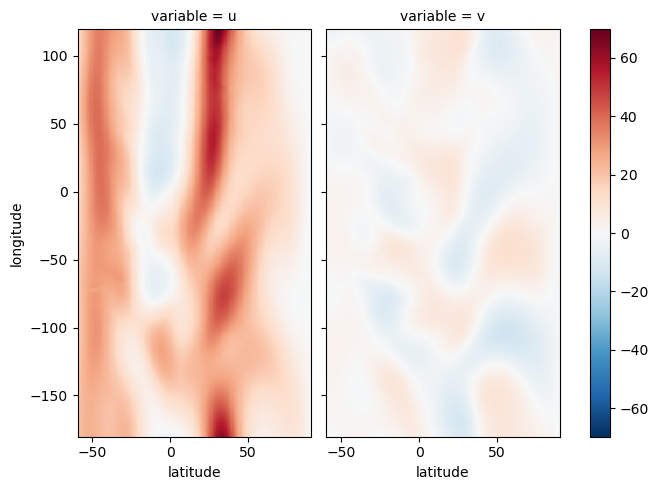

In [351]:
data.plot(col='variable', figsize=(7, 5))

## Visualizing the u components of the items

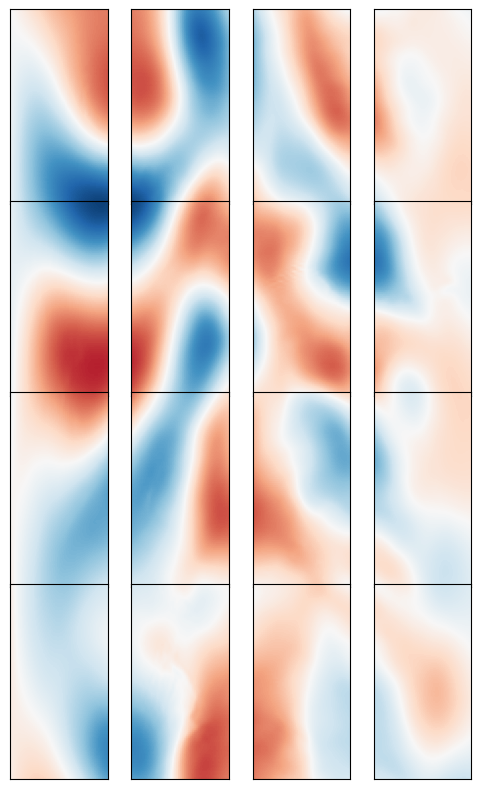

In [352]:


fig, axs = plt.subplots(4, 4, figsize=(5, 8))

for i, ax in enumerate([ ax for axx in axs for ax  in axx]):
    item = torch_ds[i]
    ax.imshow(item.v, cmap='RdBu_r', vmax=15, vmin=-15)
    ax.set_xticks([], labels=None)
    ax.set_yticks([], labels=None)
    plt.tight_layout()

## Reconstructing and plotting the u data

In [362]:
rec_ds = torch_ds.batcher.reconstruct((batch.u for batch in dataloader), dims_labels=['longitude', 'latitude'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 153.27it/s]


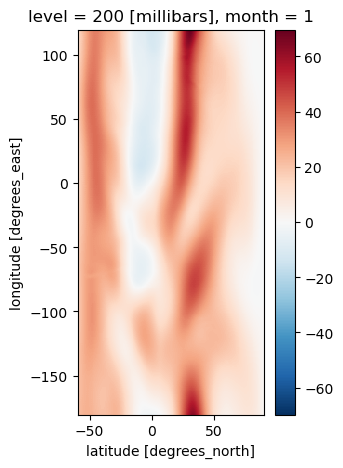

In [365]:
rec_ds.plot(figsize=(3, 5))

In [358]:
rec_ds.shape

(4, 400, 200)